In [1]:
%matplotlib notebook
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d

### Constants

In [2]:
rd = {}

volumeRange = (-10,10) #the range over which points are generated
numPoints = 15000 #the number of points generated over that range

numRays = 30
std = 3. #the standard deviation of the gaussian drop zone.
mean = np.array([-5., -5., -5.]) #the mean of the gaussian drop zone.

### Graph Builder

In [3]:
def build_graph(rd):
    xSize = 3
    x = tf.placeholder(tf.float32, shape=[None, xSize])
    y = x[:,0]*1.
    #add large cycles
    for i in range(xSize):
        r = np.random.uniform(-5., 5.)
        y = y + 3*tf.sin(x[:,i]/(10+r)+r)
    #add medium cycles
    for i in range(xSize):
        r = np.random.uniform(-2.,2.)
        y = y + 2*tf.cos(x[:,i]/(3+r)+r)
    #add short cycles
    for i in range(xSize):
        r = np.random.uniform(3.)
        y = y + 0.5*tf.sin(x[:,i]*r)
    
    rd['y'] = y
    rd['x'] = x
    rd['yPrime'] = tf.gradients(y, x)
    
build_graph(rd)
rd['sess'] = tf.Session()
rd['sess'].run(tf.initialize_all_variables())

### Generate f(x)

In [4]:
x = np.random.uniform(low=volumeRange[0], high=volumeRange[1], size=(numPoints, 3))
result = rd['sess'].run([rd['y']], feed_dict={rd['x']:x})
y = result[0]

### Generate Gradient Vectors

In [5]:
rays = np.random.multivariate_normal(mean=mean, cov=np.identity(mean.shape[0])*std, size=numRays)
grads = rd['sess'].run(rd['yPrime'], feed_dict={rd['x']:rays})
vecs = grads[0]*-1.

avgRay = np.mean(rays, axis=0)
avgVec = np.mean(vecs, axis=0)

devVec = np.mean(np.absolute(avgVec - vecs), axis=0)
print devVec

[ 0.62667066  0.94305134  0.70205504]


### Calculate Vector Intersections

In [6]:
def closest_intersections(rays, vecs):
    #see http://geomalgorithms.com/a07-_distance.html
    #O(n**2) currently. : /
    #   i think the first way to improve this will be to remove rays
    #    that do not share an acute angle in the direction of their vector?
    #    maybe choose the most acute angle relationship before going to all this effort?
    #   is there any way to do this with a sweep line?
    
    #FIXME np.diag() is used below, and the off diagonal elements are never used.
    #        so, multiply that stuff without calculating the off diagonal elements.
    
    #NOTE: np.dot(a, b) sums over the last dimension of a, and the 2nd to last of b
    #
    assert rays.shape == vecs.shape
    
    bestFront = []
    bestRear = []
    
    #calculate full vector info outside of loop.
    v = vecs  # .shape == (r, 3)
    v = np.expand_dims(v, 2)  # .shape == (r, 3, 1)
    c = np.dot(np.rollaxis(v, -1, -2), v)  # c.shape == (r, 1, r, 1)
    c = np.squeeze(c)  # c.shape == (r, r)
    #take the diagonal to only get those dotted by themselves
    c = np.diag(c)  # c.shape == (r,)  <---C
    
    
    #iterate each ray
    for i in range(rays.shape[0]):
        #print i
        
        u = vecs[i]  # .shape == (3,)
        wNil = rays[i] - rays  # .shape == (r, 3)
        wNil = np.expand_dims(wNil, 2)  # .shape == (r, 3, 1)
        
        a = np.dot(u, u)  # a.shape == (1,) <---A
        b = np.dot(u, v)  # b.shape == (r, 1, 1)
        b = np.squeeze(b)  # b.shape == (r,)  <---B
        # c.shape == (r,)  <---C
        d = np.dot(u, wNil)  # d.shape == (r, 1, 1)
        d = np.squeeze(d)  # d.shape == (r,)  <---D
        e = np.dot(np.rollaxis(v, -1, -2), wNil)  # e.shape == (r, 1, r, 1)
        e = np.squeeze(e)  # e.shape == (r, r)
        e = np.diag(e)  # e.shape == (r,)  <---E
        
        denominator = (a*c) - b**2  # .shape == (r,)
        #throw out parallel lines
        intersecting = np.where(denominator > 0)
        b_ = b[intersecting]
        c_ = c[intersecting]
        d_ = d[intersecting]
        e_ = e[intersecting]
        denominator_ = denominator[intersecting]
        
        s = ((b_*e_)-(c_*d_))/denominator_  # distance from P0 on ray[i] closest to...
        t = ((a*e_)-(b_*d_))/denominator_  # the point t distance from Q0
        
        #s.shape == (r,)
        #t.shape == (r,)
        #NOTE: positive s/t indicate that the meeting point is in front of the vector, negative indicates behind.
        
        #Get the points along the rays given s and t.
        Ps = np.expand_dims(rays[i], 0) + np.expand_dims(u, 0)*np.expand_dims(s, 1)  # .shape == (r, 3)
        Pt = rays[intersecting] + vecs[intersecting]*np.expand_dims(t, 1)  # .shape == (r, 3)
        
        
        #calculate closest intersection for ray[i]
        #  NOTE: this does not calculate the intersection closest to its origin.
        dists = (Pt-Ps)**2
        dists = dists.sum(axis=1)
        dists = np.sqrt(dists)
        
        #FIXME TODO the best intersection is some product of closeness of intersection AND in closeness to
        #             the origin of the ray.
        #             the relationships should probably be squared? so that values with both are very highly prized.
        
        #equality would be unhelpful?
        #find where both rays are pos/neg
        #   i.e. where they agree on the status of the intersection. max/min
        fIndex = np.argwhere((s > 0) & (t > 0)).squeeze(axis=1)
        print "fIndex: " + str(fIndex)
        rIndex = np.argwhere((s < 0) & (t < 0)).squeeze(axis=1)
        print "rIndex: " + str(rIndex)
        
        #we want dist to be small, and s to be small.
        #a combination of both is far greater than one or the other.
        if fIndex.size > 0:
            bestFIndex = fIndex[(s[fIndex] * dists[fIndex]).argmin()]
            
            print "bestFIndex pre argmin" + str(s[fIndex] * dists[fIndex])
            print bestFIndex
            
            midF = (Ps[bestFIndex]+Pt[bestFIndex])/2
            bestFront.append(midF)
            
            print "bestFront: (" + str(s[bestFIndex]) + ", " + str(t[bestFIndex]) + ")"
        
        if rIndex.size > 0:            
            bestRIndex = rIndex[((s[rIndex]*-1) * dists[rIndex]).argmin()]   
            
            print "bestRIndex pre argmin" + str(s[rIndex] * dists[rIndex])
            print bestRIndex
            
            midR = (Ps[bestRIndex]+Pt[bestRIndex])/2
            bestRear.append(midR)
            
            print "bestRear: (" + str(s[bestRIndex]) + ", " + str(t[bestRIndex]) + ")"
    
    return np.array(bestFront), np.array(bestRear)

fronts, rears = closest_intersections(rays, vecs)
print fronts
print rears

#print intersections

fIndex: [ 5  7  8 10 11]
rIndex: [ 0  2  6  9 13 14 15 16 17 18 19 23 24 25 26 27 28]
bestFIndex pre argmin[ 1.47603311  4.09293005  1.26004755  1.5286214   0.44248536]
11
bestFront: (1.5515441556, 1.71288944192)
bestRIndex pre argmin[-0.06410155 -2.58413362 -2.44088088 -0.06852047 -4.27260291 -1.70678146
 -0.46832027 -1.52041549 -5.17101389 -1.38559405 -6.48847114 -2.9824777
 -6.72231555 -4.11463647 -0.60931946 -5.13476876 -0.06029302]
28
bestRear: (-4.1537022151, -5.7016024261)
fIndex: [ 3  4  5  7  8 10 11 22]
rIndex: [ 0  2  6  9 12 13 14 15 16 17 18 19 23 25 26 27 28]
bestFIndex pre argmin[ 0.15847251  0.52477721  5.47485174  7.97074162  5.17831356  1.24631183
  1.24738434  1.78956693]
3
bestFront: (0.0337368965659, 0.72250592012)
bestRIndex pre argmin[ -5.18927352e-02  -1.71410444e+00  -1.39604120e+00  -8.87647660e-03
  -3.66375727e+00  -4.40908845e+00  -1.34208292e+00  -3.92328719e-01
  -1.54442242e+00  -1.81967617e+01  -1.04574494e+00  -4.21957976e+00
  -2.78663568e+00  -9.2926

## Plot

In [7]:
#transpose for easier matplotlib plotting
x = x.transpose()
y = np.squeeze(y)
rays = rays.transpose()
vecs = vecs.transpose()

<IPython.core.display.Javascript object>


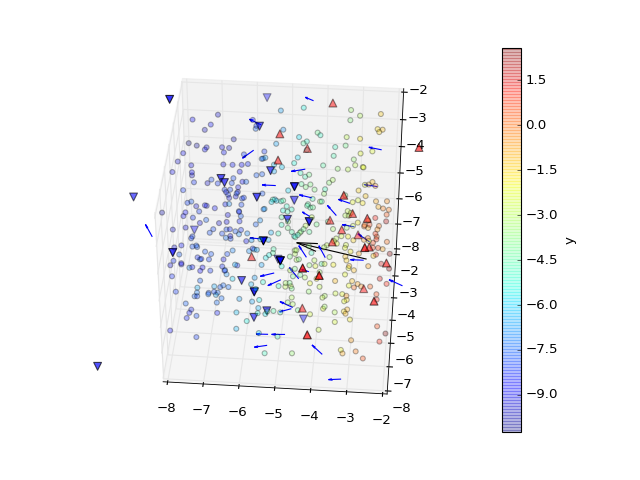

(30, 3)
(30, 3)


In [8]:
plotSplit = 110
lims = (mean-(std*2/2.), mean+(std*2/2.))

fig = plt.figure()

ax = fig.add_subplot(plotSplit+1, projection='3d') #create subplot in figure.
ax.set_xlim(lims[0][0], lims[1][0])
ax.set_ylim(lims[0][1], lims[1][1])
ax.set_zlim(lims[0][2], lims[1][2])
ptIndices = []
for i in range(x.shape[0]):
    ptIndices.append(list((x[i,:] >= lims[0][i]) & (x[i,:] <= lims[1][i])))
ptIndices = np.array(ptIndices).all(axis=0)

x1 = x[0,ptIndices]
x2 = x[1,ptIndices]
x3 = x[2,ptIndices]
#set the color map to the output dimension.
scatPlot = ax.scatter(x1, x2, x3, alpha=0.3, marker='o', c=y[ptIndices])
cb = fig.colorbar(scatPlot)
cb.set_label("y")
#cb.set_clim(vmin=y[ptIndices].min, vmax=y[ptIndices].max())

#gradient rays
ax.quiver(rays[0], rays[1], rays[2], vecs[0], vecs[1], vecs[2], length=0.4)
ax.quiver(avgRay[0], avgRay[1], avgRay[2], avgVec[0], avgVec[1], avgVec[2],
          length=2, colors=(0,0,0))

#gradient ray intersections
print fronts.shape
print rears.shape
if fronts.size >= 3:
    ax.scatter(fronts[:,0], fronts[:,1], fronts[:,2], marker='v', s=50, c=(0,0,1))
if rears.size >= 3:
    ax.scatter(rears[:,0], rears[:,1], rears[:,2], marker='^', s=50, c=(1,0,0))